# Prime Factoring by QUBO
This time, we will use a combinatorial optimization problem to perform the decomposition into two prime numbers.

## Factoring 15
Now we try factoring 15 to p and q.
p and q are prime factors

$$
15 = p*q
$$

To get p and q we solve the equation below.

$$
E=(15 - p*q)^2
$$

p and q also can write as decimal number using qubits which has binary value.

$$
p = 1+2q_0+4q_1 \\
q = 1+2q2
$$

substitute these and we get equation below.

$$
E = \{15-(1+2q_0+4q_1)(1+2q_2)\}^2
$$

In [ ]:
def qaoa(hamiltonian, step, init = None, mixer = None):
    import numpy as np
    import scipy.optimize as optimize
    from blueqat import Circuit
    from blueqat.pauli import qubo_bit as q
    
    hamiltonian = hamiltonian.to_expr().simplify()
    N = hamiltonian.max_n()
    
    time_evolutions_cost = [
        term.get_time_evolution() for term in hamiltonian
    ] 
    
    time_evolutions_mixer = [
        term.get_time_evolution() for term in mixer
    ] if mixer else []
    
    def f(params):
        params = params%(np.pi*2)
        betas =  params[:step]
        gammas =  params[step:]

        if init is None:
            c = Circuit(N).h[:]
        else:
            c = init
    
        for beta, gamma in zip(betas, gammas):
            for evo in time_evolutions_cost:
                evo(c, gamma)
            if mixer is None:
                c.rx(beta)[:]
            else:
                for evo in time_evolutions_mixer:
                    evo(c, beta)
    
        return c.run(backend="quimb", hamiltonian=hamiltonian)
    
    #number of params
    initial_guess = np.array([
        np.random.rand()*np.pi*2 for _ in range(step * 2)
    ])
    
    result = optimize.minimize(f, initial_guess, method="Powell",
                                                          options={
                                                              "ftol": 5.0e-2,
                                                              "xtol": 5.0e-2,
                                                              "maxiter": 1000
                                                          })
    
    if result.success:
        fitted_params = result.x
        betas = fitted_params[:step]
        gammas = fitted_params[step:]

        if init is None:
            circ = Circuit(N).h[:]
        else:
            circ = init
    
        for beta, gamma in zip(betas, gammas):
            for evo in time_evolutions_cost:
                evo(circ, gamma)
            if mixer is None:
                circ.rx(beta)[:]
            else:
                for evo in time_evolutions_mixer:
                    evo(circ, beta)
        result = type('', (), {})
        result.params = fitted_params
        result.circuit = circ
        
        return result
    else:
        return ValueError(result.message)

In [63]:
from blueqat import vqe
from blueqat.pauli import qubo_bit as q

hamiltonian = (15-(1+2*q(0)+4*q(1))*(1+2*q(2)))**2
step = 4


result = qaoa(hamiltonian, step)

In [64]:
result.circuit.run(backend="quimb", shots=1000)

Counter({'111': 376,
         '011': 419,
         '101': 151,
         '001': 16,
         '110': 20,
         '000': 14,
         '100': 4})

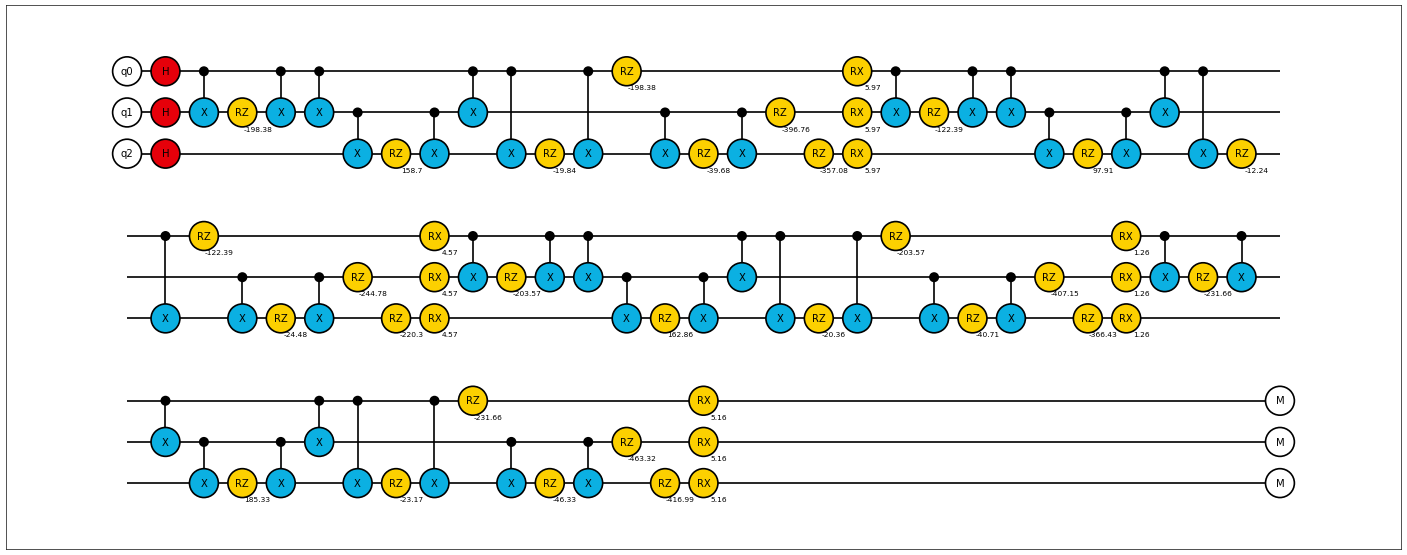

In [65]:
result.circuit.run(backend="draw")

## Solve the QUBO with QAOA
By using QAOA we can easily solve the upper problem.

In [66]:
from blueqat import vqe
from blueqat.pauli import qubo_bit as q

hamiltonian = (15-(1+2*q(0)+4*q(1))*(1+2*q(2)))**2
step = 4

result = vqe.Vqe(vqe.QaoaAnsatz(hamiltonian, step)).run()
print(result.most_common(12))

(((0, 1, 1), 0.7750059522750616), ((1, 0, 1), 0.059726228500385156), ((0, 1, 0), 0.05395518023107486), ((1, 1, 0), 0.03676831078172294), ((1, 1, 1), 0.035579861156200106), ((1, 0, 0), 0.015175898327479297), ((0, 0, 1), 0.01329980942163696), ((0, 0, 0), 0.010488759306437253))


Now we get (0,1,1) and it shows

$$
p = 1+2*0+4*1 = 5 \\
q = 1+2*1 = 3
$$

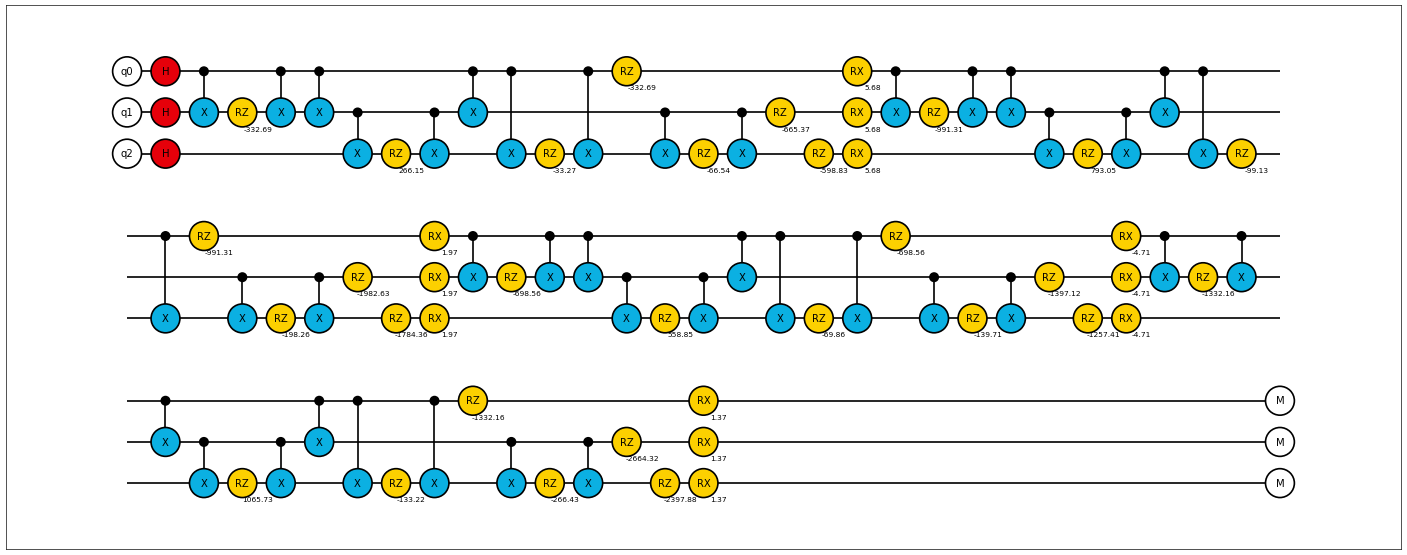

In [67]:
result.circuit.run(backend="draw")

And finally we solved the problem using QUBO and minimum problem to solve simple factoring.

In [71]:
from blueqat.pauli import qubo_bit as q

hamiltonian = (q(0)+q(2)+q(3)+q(5))**2 + (q(2)+q(5))**2 + (q(1)+q(4))**2 + (q(0)+q(3))**2 + (q(2)+q(5))**2 + (q(1)*q(4))**2 + (q(0)+q(3))**2 + (q(2)+q(5))**2 + (q(1)+q(4))**2 + (q(0)+q(1)+q(3)+q(4))**2

In [74]:
from blueqat.pauli import X, Y
from blueqat import Circuit

step = 4

#mixer and init state
mixer = 0.5*X[0]*X[1] + 0.5*Y[0]*Y[1] + 0.5*X[1]*X[2] + 0.5*Y[1]*Y[2] + 0.5*X[2]*X[0] + 0.5*Y[2]*Y[0]
mixer += 0.5*X[3]*X[4] + 0.5*Y[3]*Y[4] + 0.5*X[4]*X[5] + 0.5*Y[4]*Y[5] + 0.5*X[5]*X[3] + 0.5*Y[5]*Y[3]
init = Circuit(6).x[0].x[3]

In [ ]:
result = qaoa(hamiltonian, step, init, mixer)

In [ ]:
result.circuit.run(backend="quimb", shots=100)

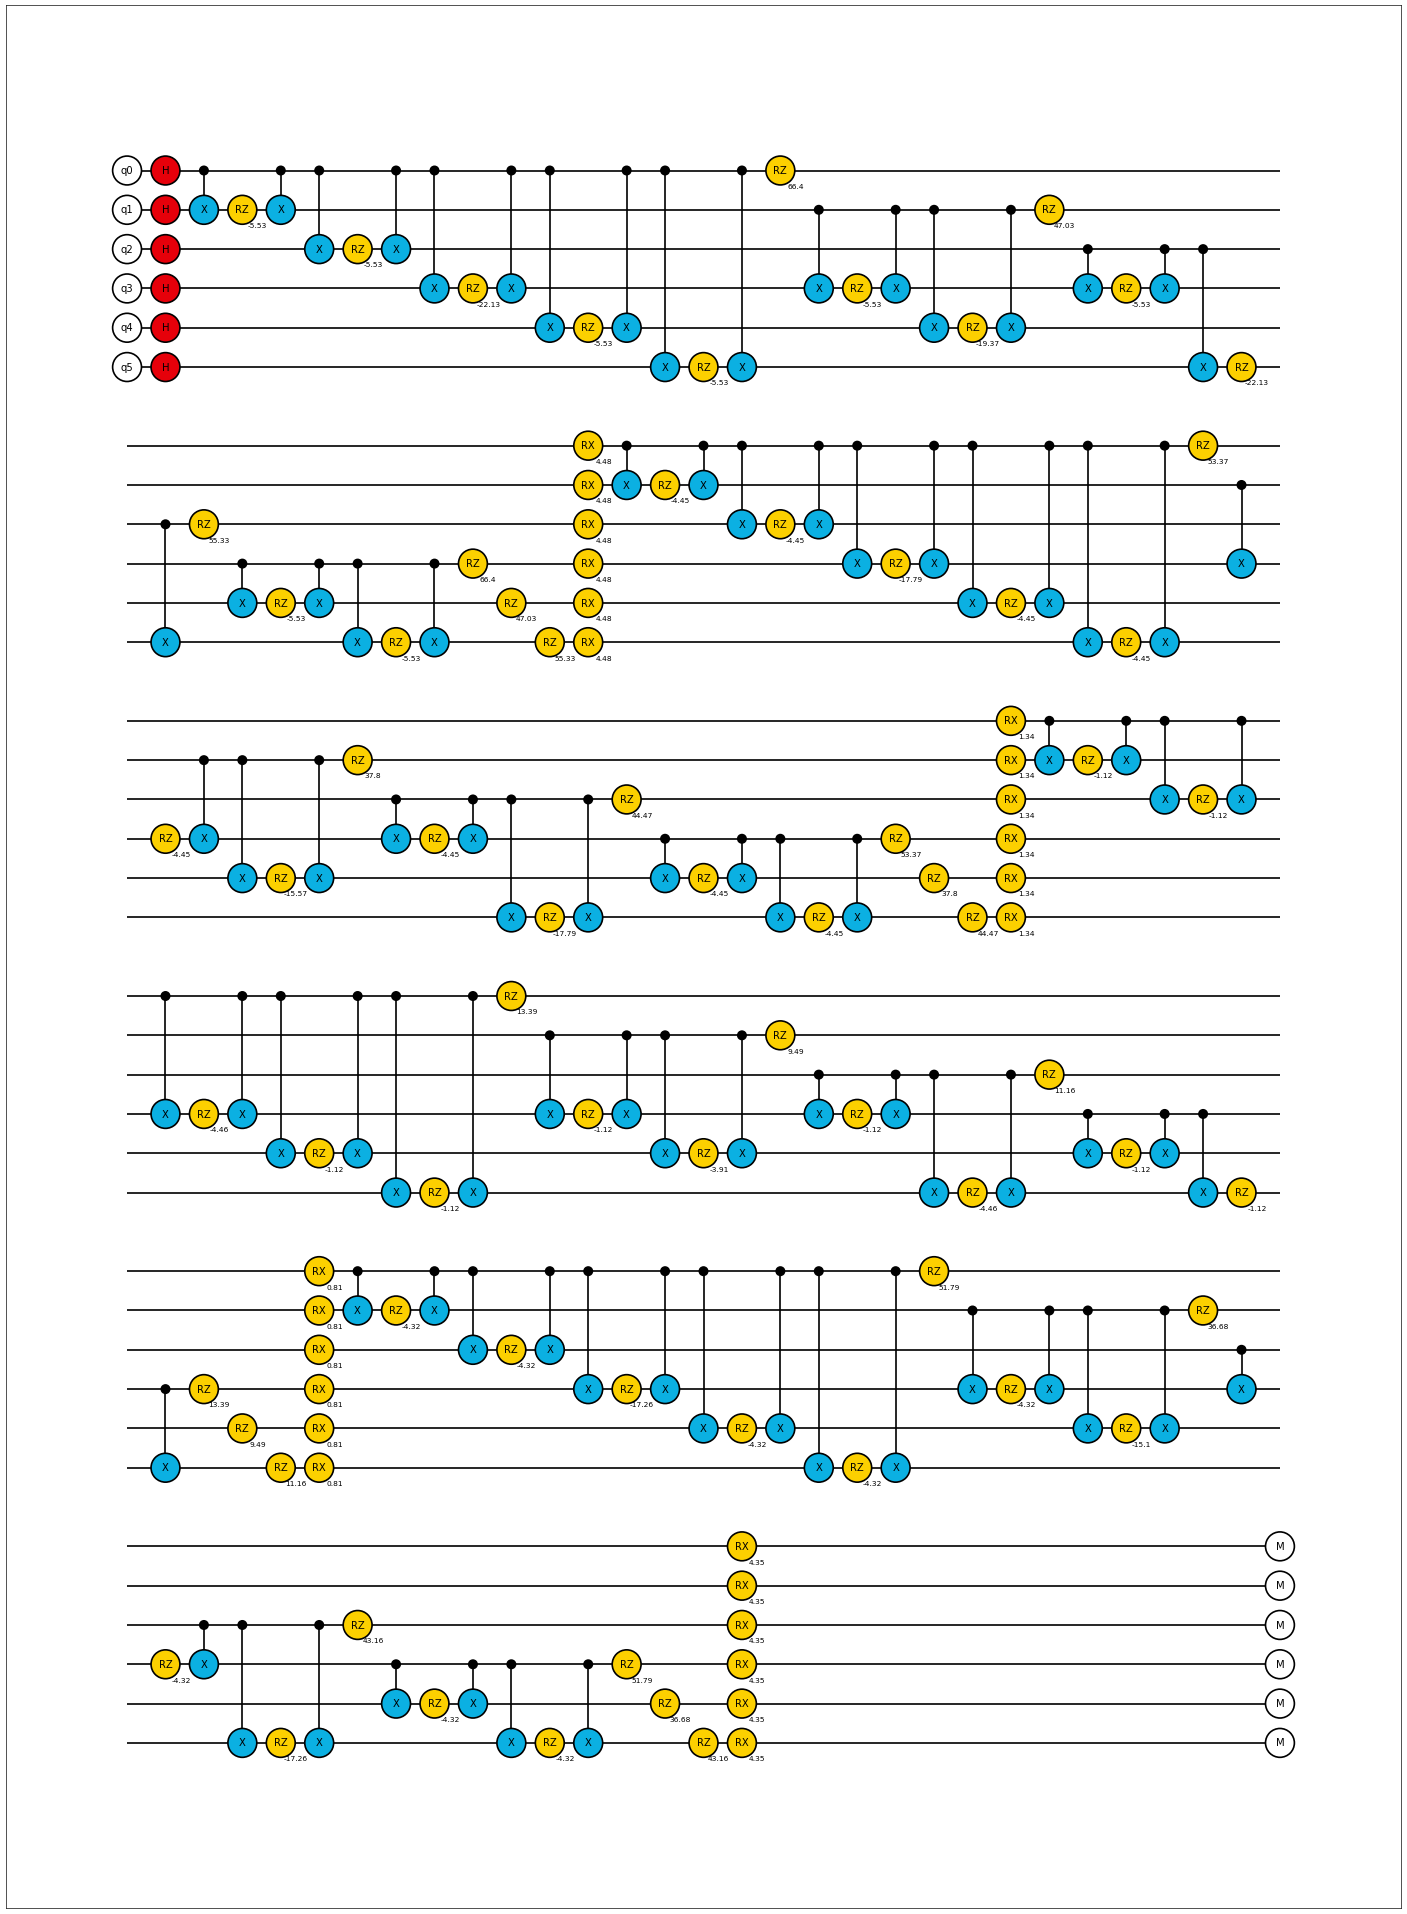

In [77]:
result.circuit.run(backend="draw")

In [ ]:
result = vqe.Vqe(vqe.QaoaAnsatz(hamiltonian, step, init, mixer)).run()
print(result.most_common(12))

In [ ]:
result.circuit.run(backend="draw")